## Task 0 

In [25]:
#!/usr/bin/env python3
"""This module creates the conv_forward function"""
import numpy as np


def conv_forward(A_prev, W, b, activation, padding="same", stride=(1, 1)):
    """
    Performs forward propagation over a convolutional layer of a neural 
    network
    
    Inputs:
    * A_prev - numpy.ndarray of shape (m, h_prev, w_prev, c_prev) 
        containing the output of the previous layer
        * m - number of examples
        * h_prev - height of the previous layer
        * w_prev - width of the previous layer
        * c_prev - number of channels in the previous layer
    * W - numpy.ndarray of shape (kh, kw, c_prev, c_new) 
        containing the kernels for the convolution
        * kh - filter height
        * kw - filter width
        * c_prev - number of channels in the previous layer
        * c_new - number of channels in the output
    * b - numpy.ndarray of shape (1, 1, 1, c_new) containing the 
        biases applied to the convolution
    * activation - activation function applied to the convolution
    * padding - string that is either same or valid, indicating the type of 
        padding used
    * stride - tuple of (sh, sw) containing the strides for the convolution
        * sh - stride for the height
        * sw - stride for the width

    Returns:
    Output of the convolutional layer
    """
    m, h_prev, w_prev, c_prev = A_prev.shape
    kh, kw, c_prev, c_new = W.shape
    sh, sw = stride

    if padding == "valid":
        ph, pw = 0, 0
    elif padding == "same":
        ph = (((h_prev - 1) * sh) + kh - h_prev) // 2
        pw = (((w_prev - 1) * sw) + kw - w_prev) // 2
    
    images = np.pad(A_prev, ((0, 0), (ph, ph), (pw, pw), (0, 0)))

    height = ((h_prev + (2 * ph) - kh) // sh) + 1
    weight = ((w_prev + (2 * pw) - kw) // sw) + 1
    
    conv_matrix = np.zeros((m, height, weight, c_new))
    
    for i in range(height):
        for j in range(weight):
            for k in range(c_new):
                v_start = i * sh
                v_end = v_start + kh
                h_start = j * sw
                h_end = h_start + kw
                kernel = W[:, :, :, k]
                output = np.multiply(images[:, v_start:v_end, h_start:h_end],
                                        kernel)
                conv_matrix[:, i, j, k] = (np.sum(output, axis=(1, 2, 3)))
    return activation(conv_matrix + b)

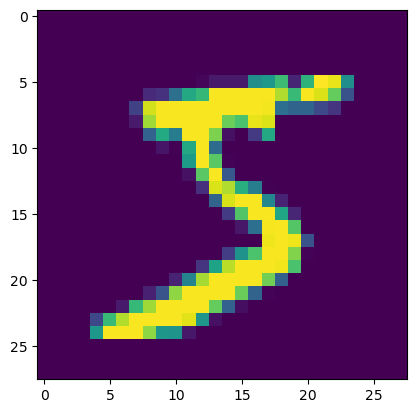

(50000, 26, 26, 2)


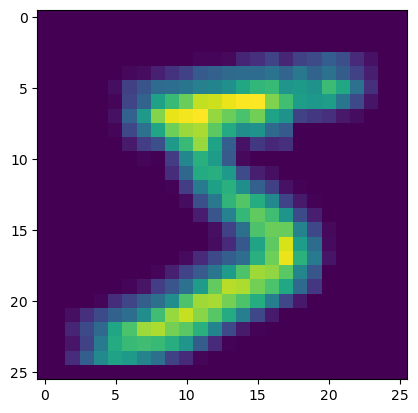

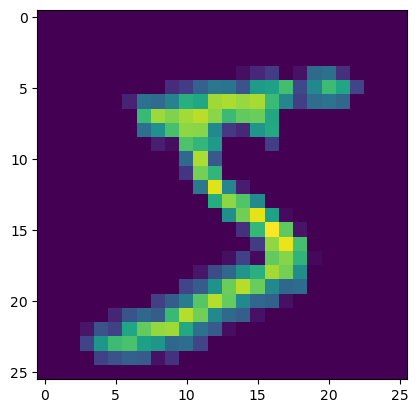

In [26]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    np.random.seed(0)
    lib = np.load('../data/MNIST.npz')
    X_train = lib['X_train']
    m, h, w = X_train.shape
    X_train_c = X_train.reshape((-1, h, w, 1))

    W = np.random.randn(3, 3, 1, 2)
    b = np.random.randn(1, 1, 1, 2)

    def relu(Z):
        return np.maximum(Z, 0)

    plt.imshow(X_train[0])
    plt.show()
    A = conv_forward(X_train_c, W, b, relu, padding='valid')
    print(A.shape)
    plt.imshow(A[0, :, :, 0])
    plt.show()
    plt.imshow(A[0, :, :, 1])
    plt.show()

## Task 1

In [27]:
#!/usr/bin/env python3
"""This module creates the pool_forward function"""
import numpy as np


def pool_forward(A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """
    Performs forward propagation over a pooling layer of a neural network
    
    Inputs:
    * A_prev - numpy.ndarray of shape (m, h_prev, w_prev, c_prev) 
        containing the output of the previous layer
        * m - number of examples
        * h_prev - height of the previous layer
        * w_prev - width of the previous layer
        * c_prev - number of channels in the previous layer
    * kernel_shape is a tuple of (kh, kw) containing the size 
        of the kernel for the pooling 
        * kh - filter height
        * kw - filter width
    * stride - tuple of (sh, sw) containing the strides for the convolution
        * sh - stride for the height
        * sw - stride for the width
    * mode is a string containing either max or avg, indicating whether to 
        perform maximum or average pooling, respectively

    Returns:
    Output of the pooling layer
    """
    m, h_prev, w_prev, c_prev = A_prev.shape
    kh, kw = kernel_shape
    sh, sw = stride

    height = ((h_prev - kh) // sh) + 1
    weight = ((w_prev - kw) // sw) + 1
    
    conv_matrix = np.zeros((m, height, weight, c_prev))
    
    for i in range(height):
        for j in range(weight):
            v_start = i * sh
            v_end = v_start + kh
            h_start = j * sw
            h_end = h_start + kw

            output = A_prev[:, v_start:v_end, h_start:h_end, :]
            if mode == "max":
                conv_matrix[:, i, j, :] = np.max(output, axis=(1, 2))
            elif mode == "avg":
                conv_matrix[:, i, j, :] = np.mean(output, axis=(1, 2))

    return conv_matrix

(50000, 28, 28, 2)


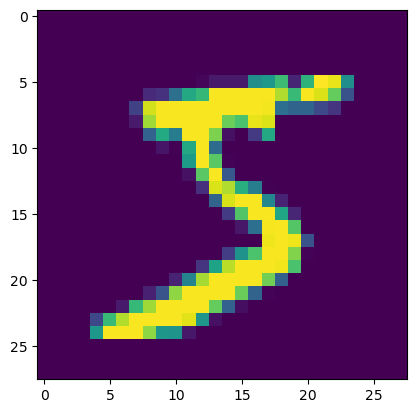

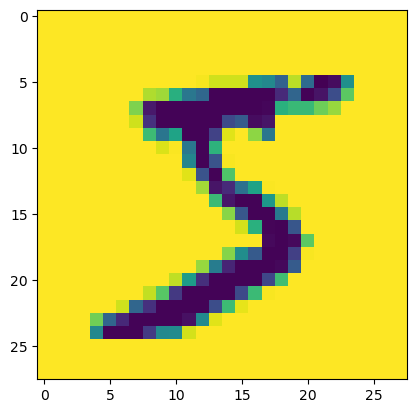

(50000, 14, 14, 2)


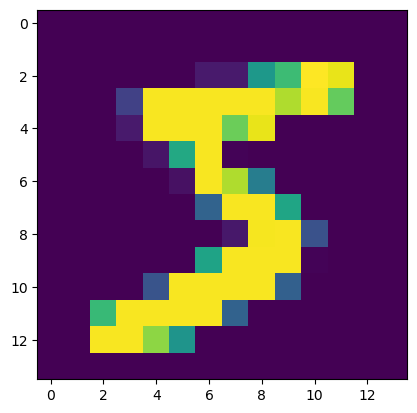

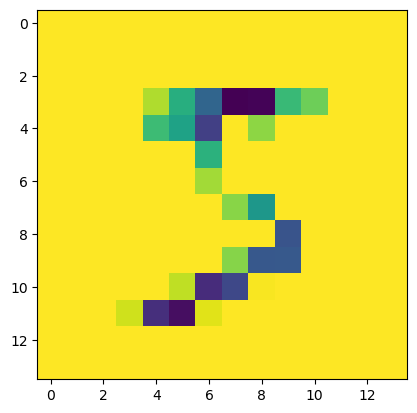

In [29]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    np.random.seed(0)
    lib = np.load('../data/MNIST.npz')
    X_train = lib['X_train']
    m, h, w = X_train.shape
    X_train_a = X_train.reshape((-1, h, w, 1))
    X_train_b = 1 - X_train_a
    X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

    print(X_train_c.shape)
    plt.imshow(X_train_c[0, :, :, 0])
    plt.show()
    plt.imshow(X_train_c[0, :, :, 1])
    plt.show()
    A = pool_forward(X_train_c, (2, 2), stride=(2, 2))
    print(A.shape)
    plt.imshow(A[0, :, :, 0])
    plt.show()
    plt.imshow(A[0, :, :, 1])
    plt.show()

## Task 2

In [45]:
#!/usr/bin/env python3
"""This module creates the conv_backward function"""
import numpy as np


def conv_backward(dZ, A_prev, W, b, padding="same", stride=(1, 1)):
    """
    Performs back propagation over a convolutional layer of a neural 
    network
    
    Inputs:
    * dZ - numpy.ndarray of shape (m, h_new, w_new, c_new) containing the
        partial derivatives with respect to the unactivated output of the
        convolutional layer
        * m - number of examples
        * h_new - height of the output
        * w_new - width of the output
        * c_new - number of channels in the output
    * A_prev - numpy.ndarray of shape (m, h_prev, w_prev, c_prev) 
        containing the output of the previous layer
        * m - number of examples
        * h_prev - height of the previous layer
        * w_prev - width of the previous layer
        * c_prev - number of channels in the previous layer
    * W - numpy.ndarray of shape (kh, kw, c_prev, c_new) 
        containing the kernels for the convolution
        * kh - filter height
        * kw - filter width
        * c_prev - number of channels in the previous layer
        * c_new - number of channels in the output
    * b - numpy.ndarray of shape (1, 1, 1, c_new) containing the 
        biases applied to the convolution
    * padding - string that is either same or valid, indicating the type of 
        padding used
    * stride - tuple of (sh, sw) containing the strides for the convolution
        * sh - stride for the height
        * sw - stride for the width

    Returns:
    Partial derivatives with respect to the previous layer (dA_prev),
    the kernels (dW), and the biases (db), respectively
    """
    m, h_new, w_new, c_new = dZ.shape
    m, h_prev, w_prev, c_prev = A_prev.shape
    kh, kw, c_prev, c_new = W.shape
    sh, sw = stride

    if padding == "valid":
        ph, pw = 0, 0
    elif padding == "same":
        ph = (((h_prev - 1) * sh) + kh - h_prev) // 2 + 1
        pw = (((w_prev - 1) * sw) + kw - w_prev) // 2 + 1
    
    padded_image = np.pad(A_prev, ((0, 0), (ph, ph), (pw, pw), (0, 0)))
    dA_prev = np.zeros((m, h_prev + (2 * ph), w_prev + (2 * pw), c_prev))
    dW = np.zeros((kh, kw, c_prev, c_new))
    db = np.sum(dZ, axis=(0, 1, 2), keepdims=True)

    for i in range(m):
        for j in range(c_new):
            for k in range(h_new):
                for l in range(w_new):
                    v_start = k * sh
                    v_end = v_start + kh
                    h_start = l * sw
                    h_end = h_start + kw
                    padded_slice = padded_image[i, v_start:v_end, h_start:h_end, :]
                    dA_prev[i, v_start:v_end, h_start:h_end, :] += W[:, :, :, j] * dZ[i, k, l, j]
                    dW[:, :, :, j] += padded_slice * dZ[i, k, l, j]
    if padding == "same":
        dA_prev = dA_prev[:, ph:-ph, pw:-pw, :]
    return dA_prev, dW, db

In [46]:
#!/usr/bin/env python3

import numpy as np

if __name__ == "__main__":
    np.random.seed(0)
    lib = np.load('../data/MNIST.npz')
    X_train = lib['X_train']
    _, h, w = X_train.shape
    X_train_c = X_train[:10].reshape((-1, h, w, 1))

    W = np.random.randn(3, 3, 1, 2)
    b = np.random.randn(1, 1, 1, 2)

    dZ = np.random.randn(10, h - 2, w - 2, 2)
    print(conv_backward(dZ, X_train_c, W, b, padding="valid"))

(array([[[[-4.24205748],
         [ 0.19390938],
         [-2.80168847],
         ...,
         [-2.93059274],
         [-0.74257184],
         [ 1.23556676]],

        [[-1.00865794],
         [ 0.24929631],
         [ 2.99153975],
         ...,
         [ 0.43357888],
         [ 4.96415936],
         [-0.44667327]],

        [[-1.87909273],
         [-1.52898354],
         [-1.03988664],
         ...,
         [-2.08719794],
         [ 0.72118428],
         [ 0.43712847]],

        ...,

        [[-1.85981381],
         [-4.35543293],
         [ 3.57636107],
         ...,
         [ 2.11136296],
         [ 0.53958723],
         [-3.52000282]],

        [[-1.0499573 ],
         [-2.04696766],
         [-3.65137871],
         ...,
         [-0.52756967],
         [-0.08825488],
         [ 0.62158883]],

        [[-0.33383597],
         [-0.68426308],
         [-1.16737412],
         ...,
         [ 0.38028383],
         [ 0.90910959],
         [ 1.1018034 ]]],


       [[[ 1.3242862 ],

## Task 3

In [58]:
#!/usr/bin/env python3
"""This module creates the pool_backward function"""
import numpy as np


def pool_backward(dA, A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """
    Performs back propagation over a pooling layer of a neural network

    Inputs:
    * dA - numpy.ndarray of shape (m, h_new, w_new, c) containing the
        partial derivatives with respect to the output of the pooling layer
        * m - number of examples
        * h_new - height of the output
        * w_new - width of the output
        * c - number of channels
    * A_prev - numpy.ndarray of shape (m, h_prev, w_prev, c_prev)
        containing the output of the previous layer
        * m - number of examples
        * h_prev - height of the previous layer
        * w_prev - width of the previous layer
        * c_prev - number of channels in the previous layer
    * kernel_shape is a tuple of (kh, kw) containing the size
        of the kernel for the pooling
        * kh - filter height
        * kw - filter width
    * stride - tuple of (sh, sw) containing the strides for the convolution
        * sh - stride for the height
        * sw - stride for the width
    * mode is a string containing either max or avg, indicating whether to
        perform maximum or average pooling, respectively

    Returns:
    Output of the pooling layer
    """
    m, h_new, w_new, c = dA.shape
    m, h_prev, w_prev, c_prev = A_prev.shape
    kh, kw = kernel_shape
    sh, sw = stride

    dA_prev = np.zeros((m, h_prev, w_prev, c))
    for ex in range(m):
        for kernel_index in range(c):
            for h in range(h_new):
                for w in range(w_new):
                    i = h * sh
                    j = w * sw
                    if mode is 'max':
                        pool = A_prev[ex, i: i + kh, j: j + kw, kernel_index]
                        mask = np.where(pool == np.max(pool), 1, 0)
                    elif mode is 'avg':
                        mask = np.ones((kh, kw))
                        mask /= (kh * kw)
                    dA_prev[ex, i: i + kh, j: j + kw, kernel_index] += (
                        mask * dA[ex, h, w, kernel_index])
    return dA_prev

In [59]:
#!/usr/bin/env python3

import numpy as np

if __name__ == "__main__":
    np.random.seed(0)
    lib = np.load('../data/MNIST.npz')
    X_train = lib['X_train']
    _, h, w = X_train.shape
    X_train_a = X_train[:10].reshape((-1, h, w, 1))
    X_train_b = 1 - X_train_a
    X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

    dA = np.random.randn(10, h // 3, w // 3, 2)
    print(pool_backward(dA, X_train_c, (3, 3), stride=(3, 3)))

[[[[ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   ...
   [ 1.49407907 -0.20515826]
   [ 1.49407907 -0.20515826]
   [ 0.          0.        ]]

  [[ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   ...
   [ 1.49407907 -0.20515826]
   [ 1.49407907 -0.20515826]
   [ 0.          0.        ]]

  [[ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   ...
   [ 1.49407907 -0.20515826]
   [ 1.49407907 -0.20515826]
   [ 0.          0.        ]]

  ...

  [[ 2.38314477  0.94447949]
   [ 2.38314477  0.94447949]
   [ 2.38314477  0.94447949]
   ...
   [-0.49803245  1.92953205]
   [-0.49803245  1.92953205]
   [ 0.          0.        ]]

  [[ 2.38314477  0.94447949]
   [ 2.38314477  0.94447949]
   [ 2.38314477  0.94447949]
   ...
   [-0.49803245  1.92953205]
   [-0.49803245  1.92953205]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]
   [ 0.          0. 